In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads

Oracle Data Science service sample notebook.

Copyright (c) 2020, 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Introduction to Streaming</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

The Oracle Cloud Infrastructure Streaming service provides a fully managed, scalable, and durable storage solution for ingesting continuous, high-volume streams of data that you can consume and process in real-time. Streaming can be used for messaging, ingesting high-volume data such as application logs, operational telemetry, web click-stream data, or other use cases in which data is produced and processed continually and sequentially in a publish-subscribe messaging model.

This notebook uses the `kafka-python` client to connect to the Streaming service by leveraging the Streaming kafka-compatible API. Messages are consumed and produced using the `kafka-python` client.

Developed on [Data Exploration and Manipulation](https://docs.oracle.com/en-us/iaas/data-science/using/conda-dem-fam.htm) for CPU on Python 3.7 (version 3.0)

---

## Contents:

- <a href='#streaming-concepts'>Streaming Concepts</a> 
- <a href='#setup'>Setup</a>
    - <a href='#create-stream'>Creating a Stream and a Stream Pool</a>
    - <a href='auth_token'>Authentication Token</a>
    - <a href='credentials'>Credentials</a>
- <a href='#producing'>Producing Messages to a Stream</a>
- <a href='#consuming'>Consuming Messages from a Stream</a> 
- <a href='#ref'>References</a>

---

Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.

---


In [ ]:
import random

from os import path
from kafka import KafkaConsumer, KafkaProducer

<a id='streaming-concepts'></a>
# Streaming Concepts

Review some of the Streaming concepts:

* Consumer: An entity that reads messages from one or more streams.
* Consumer Group: A set of instances that coordinates messages from all of the partitions in a stream. Instances in a consumer group maintain group membership through interaction. Lack of interaction for a period of time results in a timeout, which removes the instance from the group.
* Cursor: A pointer to a location in a stream. This location could be a pointer to a specific offset or time in a partition, or to a groups' current location.
* Message: A Base64-encoded record that is published to a stream.
* Offset: The location of a message within a partition. You can use the offset to restart reading from a stream.
* Partition: A partition is a section of a stream. Partitions allow you to distribute a stream by splitting messages across multiple nodes. Each partition can be placed on a separate machine to allow for multiple consumers to read from a stream in parallel.
* Permissions: Use Oracle Identity and Access Management (IAM) to set permissions on the list, get, update, create, and delete streams operations.
* Producer: An entity that publishes messages to a stream.
* Topic/group: An identifier used to group related messages.
* Stream: A partitioned, append-only log of messages.

<a id='setup'></a>
# Setup

<a id='create-stream'></a>
## Creating a Stream and a Stream Pool

Configured the tenancy to support the use of the Streaming service. Use the [managing streams](https://docs.cloud.oracle.com/en-us/iaas/Content/Streaming/Tasks/managingstreams.htm) instructions. Ensure that the required policies are in place before proceeding. 

The stream and stream pool need to be configured. To do this, open the Console menu and under **Solutions and Platform** section, click **Analyics**, and then click **Streaming**. Click on **Streams** and select the compartment that will contain the stream. Click **Create Stream**. If there is an existing stream pool it can be selected from the dropdown menu or a new stream pool can be created by checking the **CREATE A STREAM POOL FOR ME** checkbox. Enter a stream name and in the next cell, update `<stream-name>`.

In [ ]:
stream_name = "<stream-name>"

Click **Create Stream** and this will open the Stream Details page as the stream is being activated. Once it is active, click the link to the Stream Pool page and click **View Kafka Connection Settings**. A modal window is displayed with connection information. In the following cell, update the variables `<bootstrap_servers>` and `<username>`. The `<username>` can be parsed out of the SASL Connection Strings section where it starts with `username="..."` where the `...` is in the format `<tenancy-name>/<user-name>/<stream-pool-OCID>`.

In [ ]:
connection_parameters = {
    "bootstrap_servers": "<bootstrap_servers>",
    "sasl_plain_username": "<username>",
    "security_protocol": "SASL_SSL",
    "sasl_mechanism": "PLAIN",
}

<a id='auth_token'></a>
## Authentication Token

An authentication token is also needed to access the stream data. Create an auth token by clicking the avatar in the Console, and then select the user name. The option to create a token is under Resource. Click **Auth Token** and then click **Generate Token**. A modal window will open where a description of the token can be entered. Enter a description, such as "Kafka access for testing streaming notebook". Click **Generate Token** and when click **Copy**. This token will need to be used to authenticate to the streaming data. Copy that token to store it in a safe place as it will be needed later. Once the window is closed there is no way to retrieve the auth token again.

Please make sure to setup the oci keys, refer to the `getting_started_ipynb`.

In the next cell, update `<auth_token>` with the auth token that was just generated.

In [ ]:
connection_parameters["sasl_plain_password"] = "<auth_token>"

<a id='credentials'></a>
## Credentials

Oracle Cloud Infrastructure Vault is a service that provides the management of encryption keys and secrets. A vault is a storage container that holds these keys and secrets. The Vault service not only secures your secrets it provides a central repository that allows them to be used in different notebooks and shared with only those that need access. It is generally best practice to not store secrets, such as credentials, in notebooks. It is recommended that the `connection_parameters` dictionary is stored in the Oracle Cloud Infrastructure Vault and not the notebook. See the notebook `vault.ipynb` for details on how to do this.

<a id='producing'></a>
# Producing Messages to a Stream 

The following cell checks to make sure that the required information has been entered into the `connection_parameters` dictionary. If so, it makes a connection to the stream by calling `KafkaProducer()`. 

In [ ]:
if (
    connection_parameters["bootstrap_servers"] != "<bootstrap_servers>"
    and connection_parameters["sasl_plain_username"] != "<username>"
    and connection_parameters["sasl_plain_password"] != "<auth_token>"
):
    producer = KafkaProducer(**connection_parameters)
else:
    producer = None

The next cell publishes one hundred messages to the stream. [KafkaProducer](https://kafka-python.readthedocs.io/en/master/#kafkaproducer) provides examples of how to post various messages with associated keys. The properties shown are the minimum required properties while creating a producer and consumer, see the <a href="https://kafka-python.readthedocs.io/en/master/apidoc/KafkaProducer.html" >KafkaProducer API supported properties</a>.

In [ ]:
if producer is not None and stream_name != "<stream-name>":
    for i in range(100):
        message = "my random string {}".format(random.randint(0, 1000)).encode("utf-8")
        print(message)
        producer.send(stream_name, message)

The preceding cell checked to make sure that the stream name was updated in the notebook. However, this is not strictly necessary. If the provided `stream_name` does not exist, the Streaming service attempts to create a stream. This may fail due to limits restrictions in the tenancy. However, if it does succeed the newly created stream is displayed in the Oracle Cloud Infrastructure Console: 

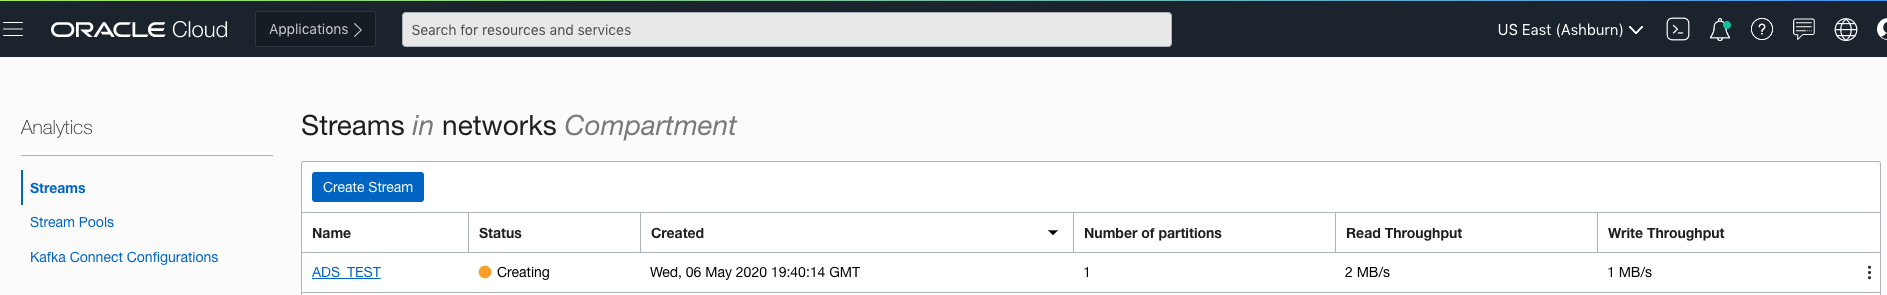

<a id='consuming'></a>
## Consuming Messages from a Stream 

These are optional properties while creating a consumer. The right set of properties depends on the use case and the requirements, see <a href="https://kafka-python.readthedocs.io/en/master/apidoc/KafkaConsumer.html">KafkaConsumer</a>.

In [ ]:
consumer_properties = {
    "auto_offset_reset": "earliest",
    "enable_auto_commit": "false",
    "group_id": "test-group",
}

if (
    connection_parameters["bootstrap_servers"] != "<bootstrap_servers>"
    and connection_parameters["sasl_plain_username"] != "<username>"
    and connection_parameters["sasl_plain_password"] != "<auth_token>"
):
    consumer = KafkaConsumer(
        stream_name, **({**connection_parameters, **consumer_properties})
    )
else:
    consumer = None

Access the messages posted on the Stream: 

In [ ]:
if consumer is not None:
    for _ in range(10):
        tmp = next(consumer)
        print(tmp.offset, tmp.value.decode("utf-8"))

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [Kafka-Python client documentation](https://kafka-python.readthedocs.io/en/master/usage.html)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [OCI Streaming service](https://docs.cloud.oracle.com/en-us/iaas/Content/Streaming/Concepts/streamingoverview.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Streaming compatibility with Kafka API and its limitations](https://docs.cloud.oracle.com/en-us/iaas/Content/Streaming/Tasks/kafkacompatibility.htm)